In [70]:
import torch
from torch import nn 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary


from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm 
from torch.optim import AdamW, Adagrad, RMSprop, Adam
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import numpy as np


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
root_dir = "/kaggle/input/apc-tank-ifv/dataset"
dataset = datasets.ImageFolder(root_dir, transform=None)

In [6]:
classes = dataset.classes

In [7]:
classes

['apc', 'ifv', 'tank']

In [8]:
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()
    ])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    ])

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
        

In [12]:
train_data = CustomDataset(train_set, transform = train_transform)
test_data = CustomDataset(test_set, transform = test_transform)
val_data = CustomDataset(val_set, transform = val_transform)

In [13]:
def output(limit, data):
    classes = ['apc', 'ifv', 'tank']
    count = 0
    for x, y in data:
        x = x.permute(1, 2, 0)
        
        plt.imshow(x)
        plt.title(classes[int(y)])
        plt.show()

        count += 1
        if count >= limit:
            break
    

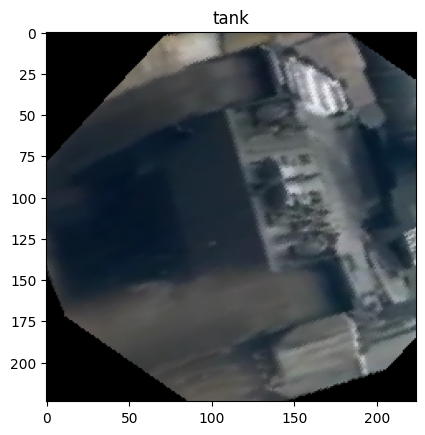

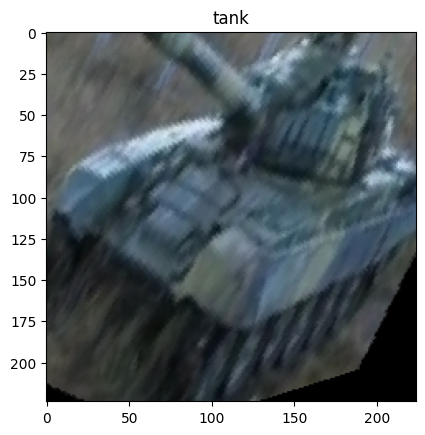

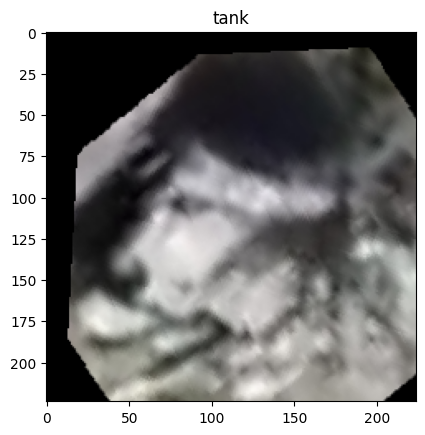

In [14]:
output(3, train_data)

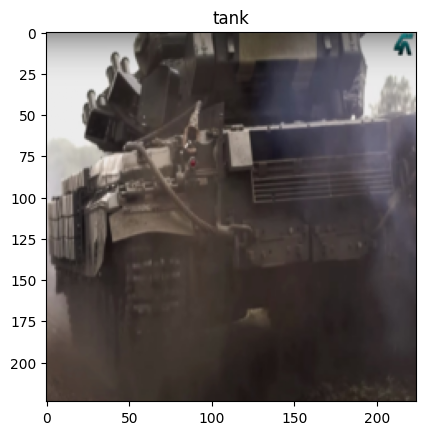

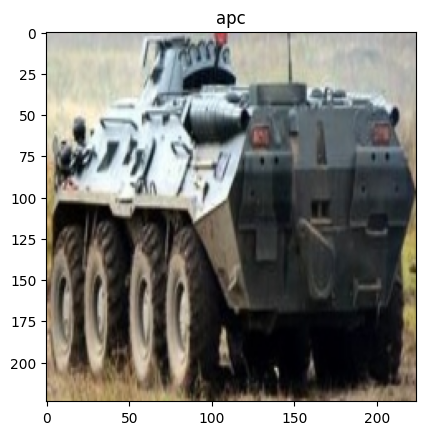

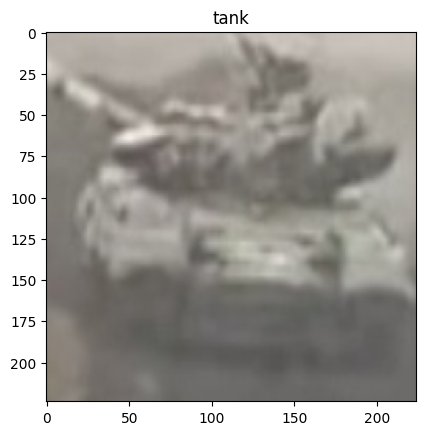

In [15]:
output(3, test_data)

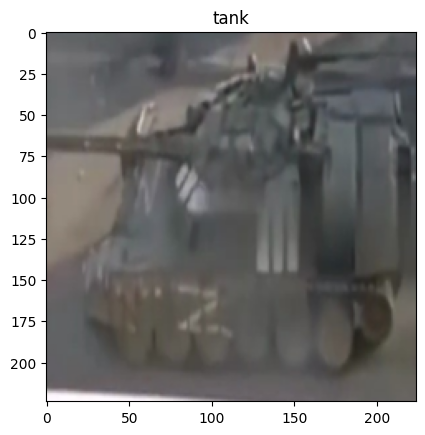

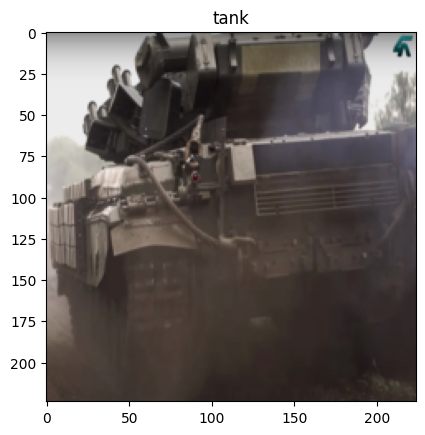

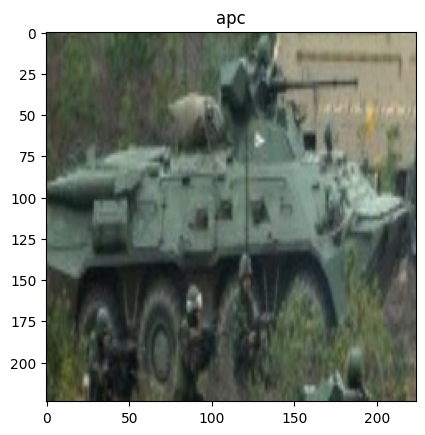

In [16]:
output(3, val_data)

In [73]:
batch_size = 256

train_dl = DataLoader(train_data, batch_size = batch_size, generator = torch.Generator(device="cpu"))
val_dl = DataLoader(val_data, batch_size = batch_size, generator = torch.Generator(device="cpu"))

In [74]:
x, y = next(iter(train_dl))
print(x.shape, y.shape)

torch.Size([256, 3, 224, 224]) torch.Size([256])


In [75]:
len(train_dl)

48

In [ ]:
# def train(model, train_dataloader, val_dataloader, loss_function, optimizer, epochs, device)

In [76]:
class SE_block(nn.Module):
    def __init__(self, C, r=16):
        super().__init__()

        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(C, C//r)
        self.linear2 = nn.Linear(C//r, C)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.aap(x)
        out = self.flatten(out)

        out = self.linear1(out)
        out = self.relu(out)

        out = self.linear2(out)
        out = self.sigmoid(out)

        out = out[:, :, None, None]

        res = x * out 

        return res



In [19]:
tensor = torch.rand(1, 32, 128, 128)
block = SE_block(32)

res = block(tensor)
res.shape

torch.Size([1, 32, 128, 128])

In [77]:
class SE_Res_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.add_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels)
            
        )
        # self.add_conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

        self.se_block = SE_block(out_channels)

    def forward(self, x):
        out = F.leaky_relu(self.bnorm1(self.conv1(x)))
        add_out = self.add_conv(x)

        # out = F.leaky_relu(out)
        out = F.leaky_relu(self.bnorm2(self.conv2(out)))
        # out = self.bnorm2(out)
        out = self.se_block(out)

        out += add_out

        return out   

In [21]:
tensor = torch.rand(1, 3, 128, 128)
block=SE_Res_block(3, 32, kernel_size=4, stride=2, padding=1)
out = block(tensor)
out.shape

torch.Size([1, 32, 64, 64])

In [125]:
class Oko(nn.Module):
    def __init__(self, outputs = 3):
        super().__init__()

        self.conv1 = SE_Res_block(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = SE_Res_block(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = SE_Res_block(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = SE_Res_block(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv5 = SE_Res_block(128, 128, kernel_size=4, stride=2, padding=1)
        
        self.conv6 = SE_Res_block(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv7 = SE_Res_block(256, 256, kernel_size=4, stride=2, padding=1)

        self.conv8 = SE_Res_block(256, 512, kernel_size=4, stride=2, padding=1)

        # self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        # self.aap = nn.AdaptiveAvgPool((1, 1))

        self.linear1 = nn.Linear(512, 128)
        self.lin_bnorm1 = nn.BatchNorm1d(128)

        self.linear2 = nn.Linear(128, 64)
        self.lin_bnorm2 = nn.BatchNorm1d(64)

        self.linear3 = nn.Linear(64, 16)
        self.lin_bnorm3 = nn.BatchNorm1d(16)

        self.linear4 = nn.Linear(16, outputs)
        # self.lin_bnorm4 = nn.BatchNorm1d(outputs)

    def forward(self, x):
        out1 = self.conv1(x)
        # print(out1.shape)
        out2 = self.conv2(out1)
        # print(out2.shape)
        out3 = self.conv3(out2)
        # print(out3.shape)

        out4 = self.conv4(out3)
        # print(out4.shape)
        out5 = self.conv5(out4)
        # print(out5.shape)


        out6 = self.conv6(out5)
        # print(out6.shape)
        out7 = self.conv7(out6)
        # print(out7.shape)
        out8 = self.conv8(out7)
        # print(out8.shape)

        # out7 = self.aap(out7)
        out = self.flatten(out8)
    
        out = F.leaky_relu(self.lin_bnorm1(self.linear1(out)))
        out = F.leaky_relu(self.lin_bnorm2(self.linear2(out)))
        out = F.leaky_relu(self.lin_bnorm3(self.linear3(out)))
        res = self.linear4(out)
        return res

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            if len(x.shape) == 3:
                x = x.unsqueeze(0)

            t_res = self.forward(x)
            t_res = torch.softmax(t_res, dim=-1)
            res = torch.argmax(t_res).item()


        return res
            

    
        

In [126]:
model = Oko()
model.to(device)

tensor = torch.rand(1, 3, 224, 224).to(device)

res = model.predict(tensor)
res

1

In [127]:
model = Oko()
model.to(device)

tensor = torch.rand(32, 3, 224, 224).to(device)

res = model(tensor)
res.shape

torch.Size([32, 3])

In [128]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]           1,568
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]           1,568
       BatchNorm2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]           9,248
       BatchNorm2d-6         [-1, 32, 112, 112]              64
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
           Flatten-8                   [-1, 32]               0
            Linear-9                    [-1, 2]              66
             ReLU-10                    [-1, 2]               0
           Linear-11                   [-1, 32]              96
          Sigmoid-12                   [-1, 32]               0
         SE_block-13         [-1, 32, 112, 112]               0
     SE_Res_block-14         [-1, 32, 1

In [129]:
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        
        model.train()
        total_train_loss = 0.0
        total_train_acc = 0.0
        # total_train_labels = []
        # total_train_preds = []

        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            outputs = model(x)

            loss = loss_fn(outputs, y)
            
            preds = torch.argmax(outputs, dim=1)
            acc = accuracy_score(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
    
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

            # preds = torch.argmax(outputs, dim=1)
            # total_train_labels.extend(y.cpu().numpy())
            # total_train_preds.extend(preds.cpu().numpy())
            


        total_train_loss /= len(train_dl)
        total_train_acc /= len(train_dl)
        # train_acc = accuracy_score(total_train_labels, total_train_preds)

        model.eval()
        total_val_loss = 0.0
        total_val_acc = 0.0
        # total_val_labels = []
        # total_val_preds = []

        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)

                outputs = model(x)
                val_loss = loss_fn(outputs, y)
                total_val_loss += val_loss.item()

                preds = torch.argmax(outputs, dim=1)
                val_acc = accuracy_score(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
                total_val_acc += val_acc.item()
                
                # total_val_preds.extend(preds.cpu().numpy())
                # total_val_labels.extend(y.cpu().numpy())

        total_val_loss /= len(val_dl)
        total_val_acc /= len(val_dl)
        # val_acc = accuracy_score(total_val_preds, total_val_labels)

        history["train_loss"].append(total_train_loss)
        history["train_acc"].append(total_train_acc)

        history["val_loss"].append(total_val_loss)
        history["val_acc"].append(total_val_acc)

        print(f'Epoch: {epoch+1}; Loss: {total_train_loss:.4f}; Accuracy: {total_train_acc:.4f}; Val_loss: {total_val_loss:.4f}; Val_acc: {total_val_acc:.4f}')
    
    return history
        

In [131]:
loss_fn = nn.CrossEntropyLoss()

# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
# optimizer = Adagrad(model.parameters(), lr=1e-3)
optimizer = Adam(model.parameters(), lr=1e-3)
# optimizer = RMSprop(model.parameters(), momentum=0.9)

In [132]:
history = train(model, train_dl, val_dl, optimizer,loss_fn, 20, device)

100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Epoch: 1; Loss: 0.8162; Accuracy: 0.6582; Val_loss: 1.1209; Val_acc: 0.5399


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Epoch: 2; Loss: 0.5445; Accuracy: 0.8196; Val_loss: 1.5168; Val_acc: 0.5758


100%|██████████| 6/6 [00:10<00:00,  1.67s/it]


Epoch: 3; Loss: 0.3917; Accuracy: 0.8693; Val_loss: 0.8174; Val_acc: 0.7103


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Epoch: 4; Loss: 0.3267; Accuracy: 0.8868; Val_loss: 0.4100; Val_acc: 0.8506


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Epoch: 5; Loss: 0.2786; Accuracy: 0.9024; Val_loss: 0.4740; Val_acc: 0.8356


100%|██████████| 6/6 [00:09<00:00,  1.60s/it]


Epoch: 6; Loss: 0.2373; Accuracy: 0.9130; Val_loss: 1.0100; Val_acc: 0.7109


100%|██████████| 6/6 [00:09<00:00,  1.64s/it]


Epoch: 7; Loss: 0.2011; Accuracy: 0.9262; Val_loss: 0.2894; Val_acc: 0.8911


100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Epoch: 8; Loss: 0.2007; Accuracy: 0.9251; Val_loss: 0.8200; Val_acc: 0.7540


100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Epoch: 9; Loss: 0.1936; Accuracy: 0.9316; Val_loss: 0.3286; Val_acc: 0.8688


100%|██████████| 6/6 [00:09<00:00,  1.63s/it]


Epoch: 10; Loss: 0.1636; Accuracy: 0.9491; Val_loss: 0.8424; Val_acc: 0.7344


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Epoch: 11; Loss: 0.1407; Accuracy: 0.9560; Val_loss: 0.0921; Val_acc: 0.9706


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Epoch: 12; Loss: 0.1263; Accuracy: 0.9619; Val_loss: 0.2360; Val_acc: 0.9132


100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Epoch: 13; Loss: 0.1282; Accuracy: 0.9602; Val_loss: 0.1125; Val_acc: 0.9720


100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Epoch: 14; Loss: 0.1250; Accuracy: 0.9612; Val_loss: 0.3940; Val_acc: 0.8734


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


Epoch: 15; Loss: 0.1101; Accuracy: 0.9676; Val_loss: 0.1897; Val_acc: 0.9262


100%|██████████| 6/6 [00:09<00:00,  1.65s/it]


Epoch: 16; Loss: 0.0897; Accuracy: 0.9748; Val_loss: 0.0812; Val_acc: 0.9733


100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


Epoch: 17; Loss: 0.0941; Accuracy: 0.9714; Val_loss: 0.9831; Val_acc: 0.7429


100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Epoch: 18; Loss: 0.0834; Accuracy: 0.9759; Val_loss: 0.1424; Val_acc: 0.9445


100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Epoch: 19; Loss: 0.0899; Accuracy: 0.9721; Val_loss: 0.3296; Val_acc: 0.8844


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]

Epoch: 20; Loss: 0.0834; Accuracy: 0.9750; Val_loss: 0.1977; Val_acc: 0.9302


In [106]:
def show_metrics(history, name):
    plt.plot(history[f"train_{name}"], label = "train")
    plt.plot(history[f"val_{name}"], label = "validation")
    plt.title(name.upper())
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.legend()

    plt.show()


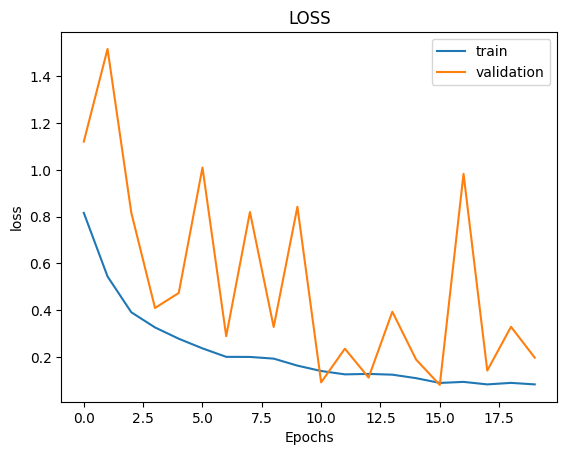

In [143]:
show_metrics(history, "loss")

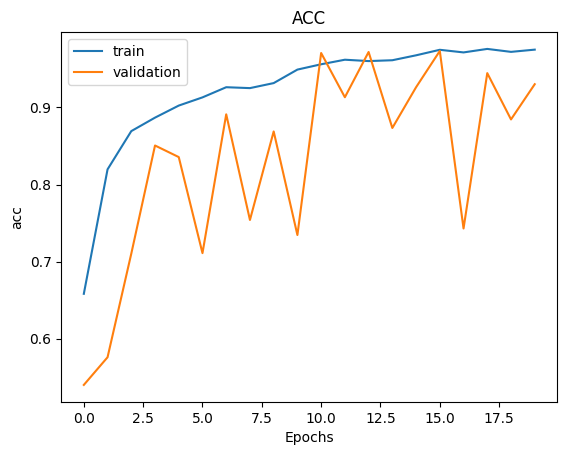

In [144]:
show_metrics(history, "acc")

In [109]:
test_dl = DataLoader(test_data, batch_size=64, generator=torch.Generator(device="cpu"))

In [110]:
def evaluate(model, test_dl):
    
    t_model = model
    t_model.to(device)
    t_model.eval()
    
    
    loss_fn = nn.CrossEntropyLoss()
    
    total_loss = 0
    total_acc = 0
    
    with torch.no_grad():
        for x, y in tqdm(test_dl):
            x = x.to(device)
            y = y.to(device)
    
            y_preds = t_model(x)
    
            curr_loss = loss_fn(y_preds, y)
            total_loss += curr_loss.item()
    
            preds = torch.argmax(y_preds, dim=1)
    
            curr_acc = accuracy_score(y.cpu().numpy(), preds.cpu().numpy())
            total_acc += curr_acc.item()
    
    losses = total_loss / len(test_dl)
    accuracy = total_acc / len(test_dl)


    print(f"[Loss: {losses:.4f}][Accuracy: {accuracy:.4f}]")

In [133]:
evaluate(model, test_dl)

100%|██████████| 24/24 [00:12<00:00,  1.87it/s]

[Loss: 0.2116][Accuracy: 0.9236]


In [38]:
tensor = torch.rand(1, 3, 224, 224).to(device)
model.predict(tensor)

2

100%|██████████| 24/24 [00:10<00:00,  2.38it/s]


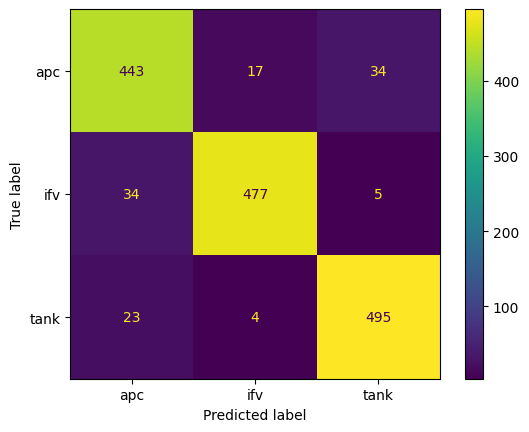

In [134]:
y_true = []
y_preds = []


with torch.no_grad():
    for x, y in tqdm(test_dl):

        x = x.to(device)
        y = y.to(device)
        
        preds = model(x)

        preds = torch.argmax(preds, dim=1)

        y_true.extend(y.cpu().numpy())
        y_preds.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_preds = np.array(y_preds)

ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels = classes)
        

In [135]:
def output_prediction(path, model, classes):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255

    image = torch.tensor(img, dtype = torch.float32).to(device)
    image = image.permute(2, 0, 1)

    res = model.predict(image)
    fin_res = classes[int(res)]

    plt.imshow(img)
    plt.title(f"Prediction: {fin_res}")
    plt.show()
    

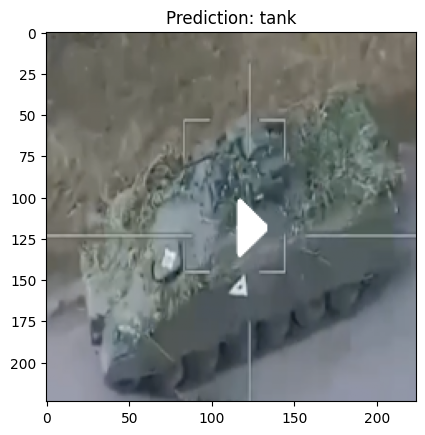

In [136]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/F_293_2309 — копия 4.jpg"
output_prediction(image, model, classes)

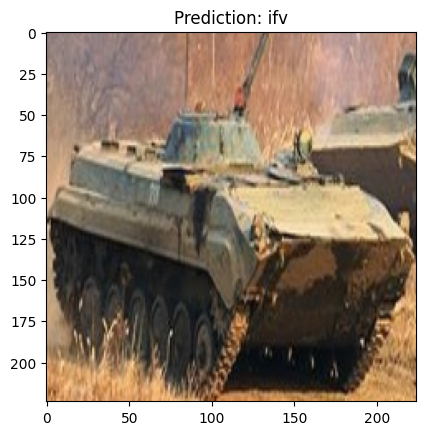

In [137]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/F_3418_612.jpg"
output_prediction(image, model, classes)

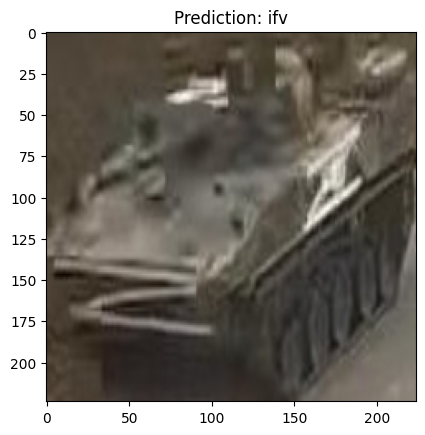

In [138]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/F_504_3977.jpg"
output_prediction(image, model, classes)

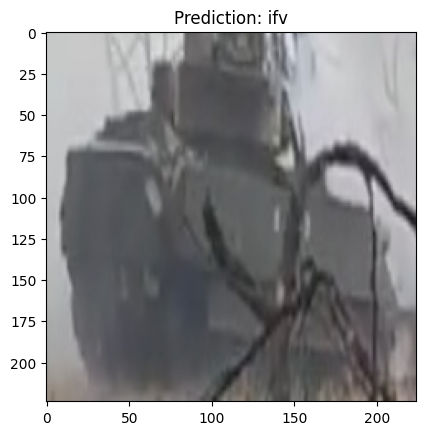

In [139]:
image = "/kaggle/input/apc-tank-ifv/dataset/ifv/photo_102_4513.jpg"
output_prediction(image, model, classes)

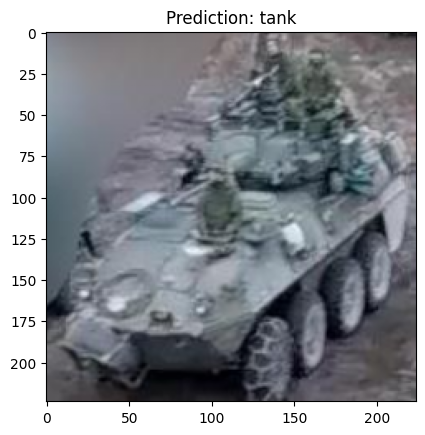

In [140]:
image = "/kaggle/input/apc-tank-ifv/dataset/apc/228_n 3.jpg"
output_prediction(image, model, classes)

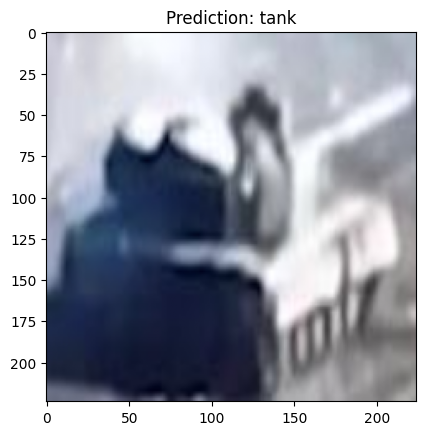

In [141]:
image = "/kaggle/input/apc-tank-ifv/dataset/tank/18_n.jpg"
output_prediction(image, model, classes)

In [142]:
torch.save(model.state_dict(), "oko_updated_4.pt")

In [59]:
t_model = Oko()
t_model.load_state_dict(torch.load("/kaggle/working/oko_updated_2.pt"))

/tmp/ipykernel_23/1186775191.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t_model.load_state_dict(torch.load("/kaggle/working/oko_updated_2.pt"))


<All keys matched successfully>

In [60]:
tensor = torch.rand(1, 3, 224, 224).to(device)
t_model.to(device)

res = t_model.predict(tensor)

res

tensor([0], device='cuda:0')